In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

In [2]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils

/home/icb/yang.an/miniconda3/envs/mvTCR_rep2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)

%load_ext autoreload
%autoreload 2

In [4]:
metadata = ['Tissue', 'Type', 'Tissue+Type', 'Sample', 'functional.cluster', 'clonotype', 'set', 'Cohort']

In [5]:
random_seed = 42
utils.fix_seeds(random_seed)

# UMAP Figures

In [6]:
holdout_cohorts = ['GSE154826',  # Lung with normal and tumor cells 18387 cells
                   'GSE162500']  # Lung with 18850 cells

mapper = {'GSE123814': 0, 'GSE114724': 1, 'GSE139555': 2, 'GSE145370': 3,
          'GSE180268': 4, 'GSE176021': 5, 'GSE148190': 6, 'GSE159251': 7,
          'CCR-20-4394': 8, 'PRJNA705464': 9, 'GSE121636': 10, 'GSE154826': 11, 'GSE162500': 12}

In [7]:
latent_with = sc.read_h5ad(f'../data/latent_moe_with_rep_leiden.h5ad')
latent_without = sc.read_h5ad(f'../data/latent_moe_without_rep_leiden.h5ad')

In [8]:
latent_with

AnnData object with n_obs × n_vars = 722461 × 50
    obs: 'batch', 'Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort', 'Cohort_held_out', 'leiden_0.01', 'leiden_0.03', 'leiden_0.1', 'leiden_0.3', 'leiden_1.0', 'leiden_3.0'
    uns: 'Cohort_colors', 'Cohort_held_out_colors', 'Tissue_colors', 'Type_colors', 'functional.cluster_colors', 'leiden', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
latent_without

AnnData object with n_obs × n_vars = 722461 × 40
    obs: 'batch', 'Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort', 'Cohort_held_out', 'leiden_0.01', 'leiden_0.03', 'leiden_0.1', 'leiden_0.3', 'leiden_1.0', 'leiden_3.0'
    uns: 'Cohort_colors', 'Cohort_held_out_colors', 'Tissue_colors', 'Type_colors', 'functional.cluster_colors', 'leiden', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [33]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)

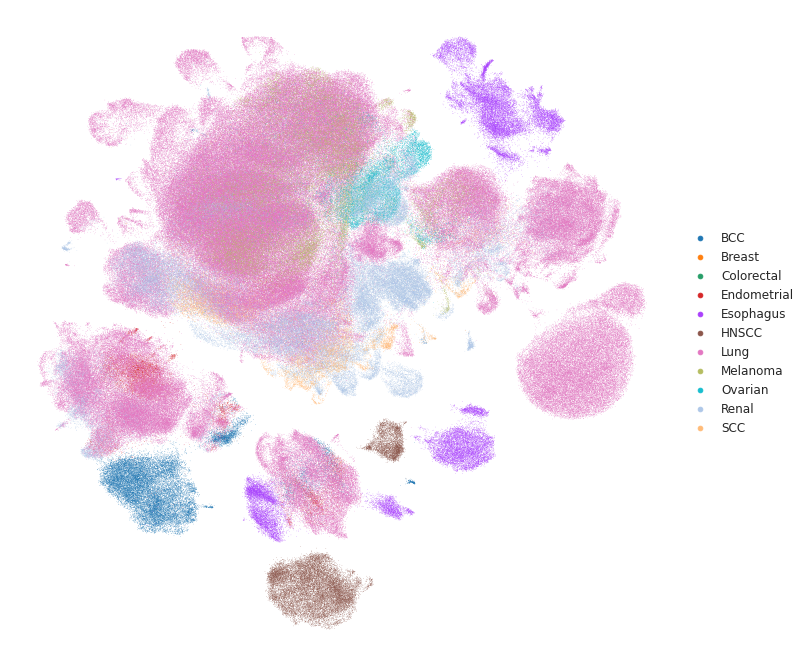

In [34]:
sc.pl.umap(latent_with, color='Tissue', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Cancer.png')

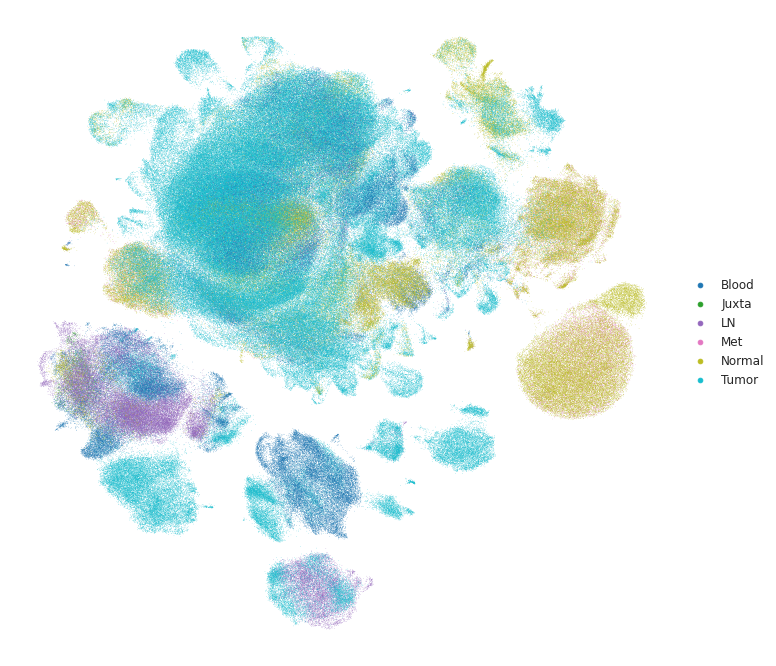

In [35]:
sc.pl.umap(latent_with, color='Type', size=1, palette='tab10', title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Origin.png')

... storing 'Cohort_held_out' as categorical


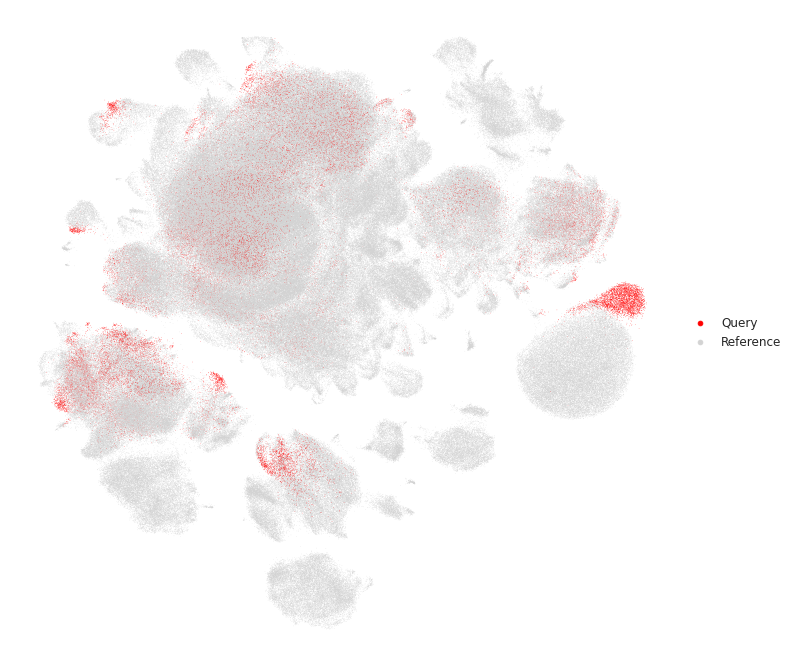

In [36]:
latent_with.uns['Cohort_held_out_colors'] = np.array(['red', 'lightgrey'], dtype=object)
latent_with.obs['Cohort_held_out'] = '.'
latent_with.obs.loc[~latent_with.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Reference'
latent_with.obs.loc[latent_with.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Query'
sc.pl.umap(latent_with, color='Cohort_held_out', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Source.png')

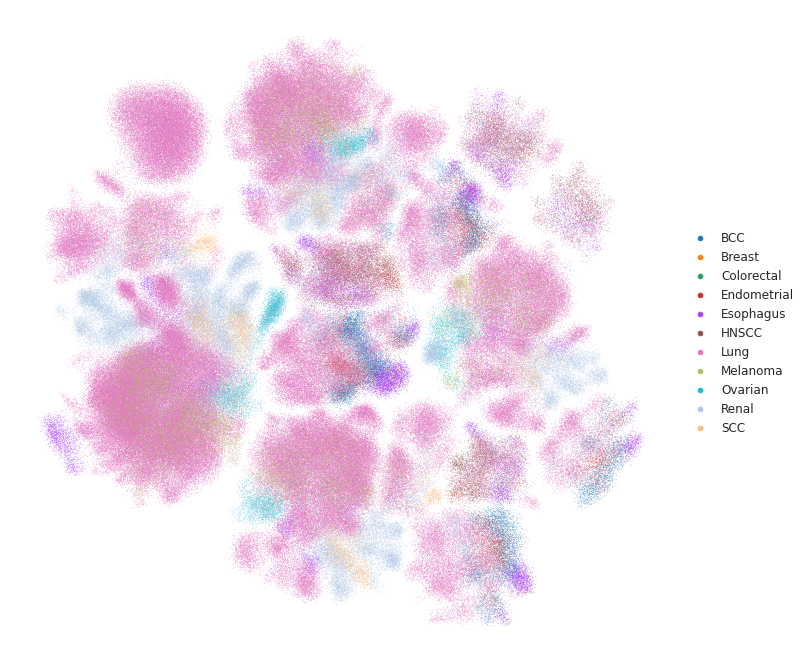

In [37]:
sc.pl.umap(latent_without, color='Tissue', size=1, ncols=2, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Cancer_wo.png')

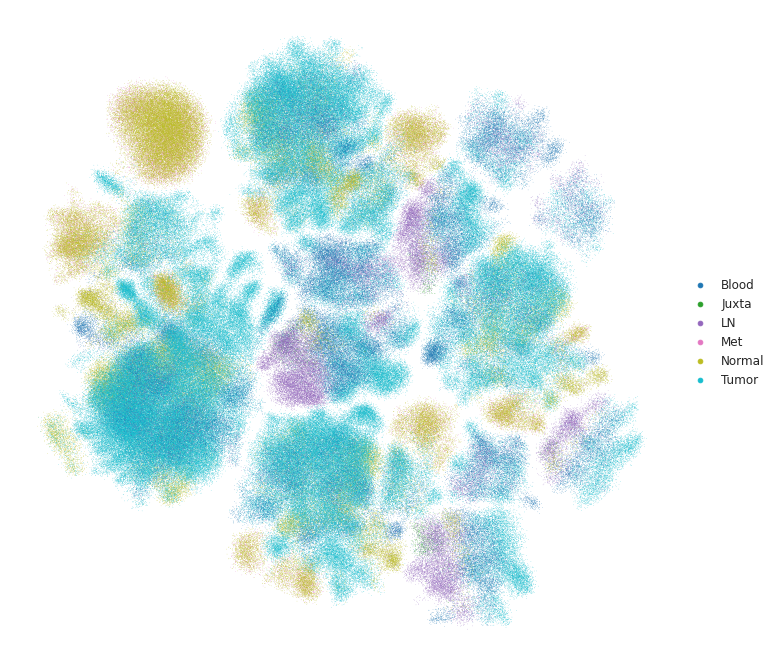

In [38]:
sc.pl.umap(latent_without, color='Type', size=1, palette='tab10', title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Origin_wo.png')

... storing 'Cohort_held_out' as categorical


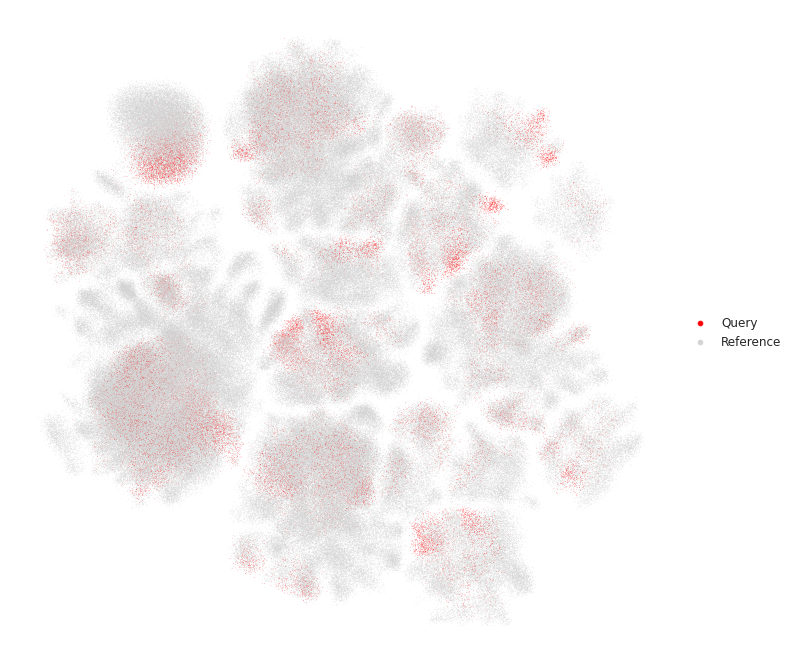

In [39]:
latent_without.uns['Cohort_held_out_colors'] = np.array(['red', 'lightgrey'], dtype=object)
latent_without.obs['Cohort_held_out'] = '.'
latent_without.obs.loc[~latent_without.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Reference'
latent_without.obs.loc[latent_without.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = 'Query'
sc.pl.umap(latent_without, color='Cohort_held_out', size=1, title='', frameon=False, legend_fontsize=12, legend_fontweight='bold', save='Source_wo.png')

# General font size setting

In [17]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title
sns.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sns.set_palette('colorblind')
set_font_size(18)

# scIB Figures

In [18]:
all_scores = pd.read_csv('../results/scib.csv', index_col=0)
all_scores = all_scores.reindex([3, 2, 4, 0, 1, 5, 9, 8, 10, 6, 7, 11]).reset_index(drop=True)  # reorder
all_scores['Value'] = all_scores['Value'].round(2)
all_scores['Method'] = all_scores['Method'].map({'MoE w/ scArches': 'mvTCR + scArches', 'MoE w/o scArches': 'mvTCR'})
all_scores

Method     Metric  Value
0   mvTCR + scArches         GC   0.82
1   mvTCR + scArches  ASW Batch   0.86
2   mvTCR + scArches        NMI   0.23
3   mvTCR + scArches        ARI   0.13
4   mvTCR + scArches        ASW   0.46
5   mvTCR + scArches    Overall   0.50
6              mvTCR         GC   0.37
7              mvTCR  ASW Batch   0.91
8              mvTCR        NMI   0.16
9              mvTCR        ARI   0.06
10             mvTCR        ASW   0.48
11             mvTCR    Overall   0.39

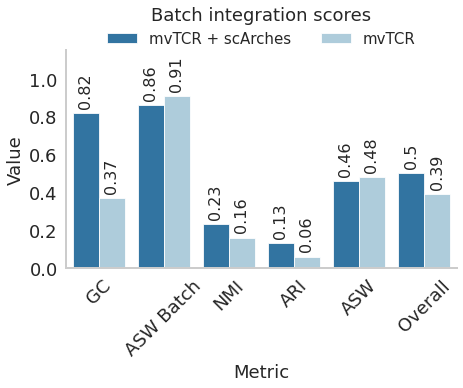

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Method', data=all_scores, palette=[sns.color_palette('Paired')[1], sns.color_palette('Paired')[0]])
ax.bar_label(ax.containers[0], rotation=90, fontsize=16, padding=5, label_type='edge')
ax.bar_label(ax.containers[1], rotation=90, fontsize=16, padding=5, label_type='edge')

plt.xlabel('Metric') 
plt.xticks(rotation=45)
plt.ylim(0, 1.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
label_dict = dict(zip(labels, handles))
order = ['mvTCR + scArches', 'mvTCR']

ax.legend([label_dict[o] for o in order], order,
          markerscale=0.5, fontsize='small', loc='upper center', frameon=False,
          bbox_to_anchor=(0.5, 1.15), ncol=2, 
          bbox_transform=ax.transAxes)

plt.title('Batch integration scores', weight='normal', pad=30)
plt.ylabel('Value')
plt.savefig(f'../figures/03_scIB.svg',bbox_inches='tight')
plt.show()

# kNN Scores

In [20]:
df = pd.read_csv('../results/kNN.csv', index_col=0)
df['Label'] = df['Label'].map({'Tissue': 'Cancer', 'Type': 'Tissue', 'Tissue+Type': 'Tissue+Type', 'functional.cluster': 'Cell Type'})
df['Value'] = df['Value'].round(2)
df['Method'] = df['Method'].map({'MoE w/ scArches': 'mvTCR + scArches', 'MoE w/o scArches': 'mvTCR'})

In [21]:
df

Method      Label  Value
0  mvTCR + scArches     Cancer   0.94
1  mvTCR + scArches     Tissue   0.70
2  mvTCR + scArches  Cell Type   0.49
3             mvTCR     Cancer   0.91
4             mvTCR     Tissue   0.60
5             mvTCR  Cell Type   0.50

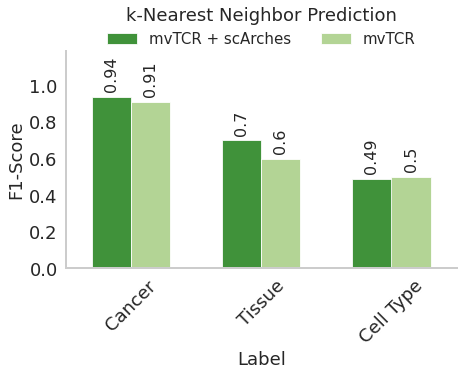

In [22]:
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.barplot(x='Label', y='Value', hue='Method', data=df, palette=[sns.color_palette('Paired')[3], sns.color_palette('Paired')[2]])

def change_width(ax, new_value):
    "https://stackoverflow.com/a/44542112"
    for i, patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        if i < len(ax.patches) // 2:
            patch.set_x(patch.get_x() + diff * .5 + diff * .5)
        else:
            patch.set_x(patch.get_x() + diff * .5 - diff * .5)


change_width(ax, .3)
ax.bar_label(ax.containers[0], rotation=90, fontsize=16, padding=5, label_type='edge')
ax.bar_label(ax.containers[1], rotation=90, fontsize=16, padding=5, label_type='edge')


plt.title('k-Nearest Neighbor Prediction', weight='normal', pad=30)
plt.xlabel('Label') 
plt.xticks(rotation=45)
plt.ylim(0, 1.19)
plt.ylabel('F1-Score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
label_dict = dict(zip(labels, handles))
order = ['mvTCR + scArches', 'mvTCR']

ax.legend([label_dict[o] for o in order], order,
          markerscale=0.5, fontsize='small', loc='upper center', frameon=False,
          bbox_to_anchor=(0.5, 1.15), ncol=2, 
          bbox_transform=ax.transAxes)

plt.savefig(f'../figures/03_kNN.svg',bbox_inches='tight')
plt.show()

# Scale Plot

In [23]:
df_mvtcr = pd.read_csv('elapsed_times_mvtcr_cleaned.csv', names=['num_samples', 'time'])
df_conga = pd.read_csv('/home/icb/yang.an/mvTCR_benchmark/conga/elapsed_times_cleaned.csv', names=['num_samples', 'time'])
df_tessa = pd.read_csv('/home/icb/yang.an/mvTCR_benchmark/TESSA/elapsed_times_cleaned.csv', names=['num_samples', 'time'])

In [24]:
df_mvtcr

num_samples         time
0          300    14.034776
1         1000    16.342088
2         3000    27.267607
3        10000    58.643500
4        30000   165.558368
5       100000   544.950237
6       300000  1772.720954
7       722461  4791.180278

In [25]:
df_conga

num_samples          time
0          300     43.704534
1         1000    100.961826
2         3000    377.710788
3        10000   1527.247334
4        30000   7593.094902
5       100000  73516.793039

In [26]:
df_tessa

num_samples           time
0          300     468.117998
1         1000    2857.621913
2         3000   10413.803009
3        10000   54196.988069
4        30000  389578.448223

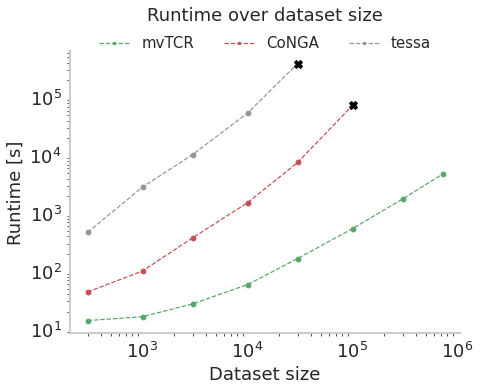

In [32]:
fig, ax = plt.subplots(figsize=(7, 5.2))

plt.plot(df_mvtcr['num_samples'], df_mvtcr['time'], 'o--', label='mvTCR', color=sns.color_palette('deep')[2])
plt.plot(df_conga['num_samples'], df_conga['time'], 'o--', label='CoNGA', color=sns.color_palette('deep')[3])
plt.plot(df_tessa['num_samples'], df_tessa['time'], 'o--', label='tessa', color=sns.color_palette('Greys', n_colors=5)[2])

plt.plot(df_conga['num_samples'].iloc[-1], df_conga['time'].iloc[-1], 'X', color='black', ms=8)
plt.plot(df_tessa['num_samples'].iloc[-1], df_tessa['time'].iloc[-1], 'X', color='black', ms=8)

plt.xscale('log')
plt.yscale('log')
#plt.xlim(800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

pos = (0.5, 0.9)
handles, labels = ax.get_legend_handles_labels()
label_dict = dict(zip(labels, handles))
order = ['mvTCR', 'CoNGA', 'tessa']

ax.legend([label_dict[o] for o in order], order,
          markerscale=0.5, fontsize='small', loc='upper center', frameon=False,
          bbox_to_anchor=(0.5, 1.1), ncol=3,
          bbox_transform=ax.transAxes)

#plt.legend(['mvTCR', 'CoNGA', 'tessa'])
plt.ylabel('Runtime [s]')
plt.xlabel('Dataset size')
#plt.ylim(1e1, 1e6)
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='y', which='minor', left=True)
plt.title('Runtime over dataset size', weight='normal', pad=30)
plt.savefig(f'../figures/03_scale_plot.svg',bbox_inches='tight')